# Segmentation practice

## Dataset

We are using the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (also available [on Kaggle](https://www.kaggle.com/datasets/julinmaloof/the-oxfordiiit-pet-dataset)). It contains 37 classes of dogs and cats, about 200 images per a class, a total of about 7000 images. In this notebook we are going to use only the images and masks to perform binary semantic segmentation (classification of image pixels as background or foreground).

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

## Necessary libraries

In [2]:
#########1#########2#########3#########4#########5#########6#########7#########

# PyTorch >= 2.0 is necessary!!!
import os
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from pathlib import Path

DATA = Path(
    #'/home/dkudr/data/CV_datasets/Oxford-IIIT_Pet/')
    '/kaggle/input/the-oxfordiiit-pet-dataset')
WORKING = Path(
    #'/home/dkudr/Yandex.Disk/Development/cv_engineering/CV6-Segmentation1')
    '/kaggle/working')
BATCH_SIZE = 32

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Dataset contents

In [3]:
!tree -d {DATA} 

/kaggle/input/the-oxfordiiit-pet-dataset
├── annotations
│   ├── trimaps
│   └── xmls
└── images

4 directories


### Augmentations for the training set 

We've choosen those that don't distort the original images too much. We also resize the images to $520\times520$ and normalize them with the default mean and std values, which is needed for the pretrained model we use further.

In [4]:
train_transforms = A.Compose([
    A.HorizontalFlip(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.ISONoise(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
        A.AdvancedBlur(p=0.1)
    ]),
    A.Resize(520, 520),
    A.Normalize(),
    ToTensorV2()
    ])

valid_transforms = A.Compose([
    A.Resize(520, 520),
    A.Normalize(),
    ToTensorV2()
])

### Custom PyTorch Dataset

We split the dataset to the training and validation subsamples. The original masks having 3 types of pixels are reduced to two classes: background (0) and foreground" (1). Some images in the dataset are corrupted and cannot be read, for these cases we skip to the next images.

In [5]:
class PetDataset(Dataset):
    def __init__(self, split='train', transforms=None):
        # Train/test split
        images_train, images_test = train_test_split(
            sorted((DATA/'images').glob('*.jpg')), 
            random_state=42, shuffle=True, train_size=0.8
        )
        if split == 'train':
            self.images_filenames = images_train
        else:
            self.images_filenames = images_test

        self.transform = transforms


    def __len__(self):
        return len(self.images_filenames)
    
    
    @staticmethod
    def preprocess_mask(mask):
        """Binary "background-foreground" (0-1) mask 
           instead of the "foreground-background-edge" (1-2-3) mask
        """
        mask[mask==2] = 0
        mask[mask==3] = 1
        return mask

    
    def __getitem__(self, idx):
        # Try/except is to skip to the next idx for corrupted images
        try: 
            image_filename = self.images_filenames[idx].name
            image = cv2.imread(str(DATA/'images'/image_filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            mask = cv2.imread(str(
                DATA/'annotations/trimaps'/(image_filename
                                            .replace('.jpg', '.png'))),
                cv2.IMREAD_UNCHANGED
            )
            mask = PetDataset.preprocess_mask(mask)

            if self.transform is not None:
                transformed = self.transform(image=image, mask=mask)
                image = transformed['image']
                mask = transformed['mask']
            
            return image, mask
        
        except:
            if idx + 1 <= self.__len__():
                return self.__getitem__(idx + 1)
            else:
                raise StopIteration

The datasets and their test readout

In [6]:
train_dataset = PetDataset(transforms=train_transforms)
valid_dataset = PetDataset(split='val', transforms=valid_transforms)

#for el in tqdm(train_dataset):
#    pass
#for el in tqdm(valid_dataset):
#    pass

### Visualization to test the data and augmentations

In [7]:
def normim_to_numpy(image):
    """Converts a normalized torch.Tensor image
       to a "H,W,C" array of integers [0-255]
    """
    unnorm = A.Compose([
        A.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225 ], 
                    max_pixel_value=1.),
        A.Normalize(mean=[-0.485, -0.456, -0.406], std=[ 1., 1., 1. ], 
                    max_pixel_value=1.)])
        
    image = image.numpy().transpose((1, 2, 0))
    image = unnorm(image=image)['image']
    image = (image * 255).astype(np.uint8)
    return np.ascontiguousarray(image)


def predict_mask(model, image):
    """Predicts a binary background/foreground mask 
    """
    model.eval()
    with torch.no_grad():
        # PyTorch >= 2.0 is necessary!!!
        pred_mask = model(image.unsqueeze(0))['out'].squeeze(0, 1)
    pred_mask[pred_mask < 0] = 0
    pred_mask[pred_mask > 0] = 1
    pred_mask = pred_mask.byte()
    return pred_mask


def display_random_examples(dataset, n=2, model=None):
    if model is None:
        fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 5*n))
    else:
        fig, ax = plt.subplots(nrows=n, ncols=3, figsize=(15, 5*n))
                
    for i in range(n):
        im_tensor, mask = dataset.__getitem__(np.random.randint(len(dataset)))
        image = normim_to_numpy(im_tensor)
        
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(image)
        ax[i, 1].imshow(mask, cmap='jet', alpha=0.5)
          
        ax[i, 0].set_title('Image')
        ax[i, 1].set_title('Mask')
                 
        if model is not None:
            ax[i, 2].imshow(image)
            ax[i, 2].imshow(
                predict_mask(model, im_tensor), cmap='jet', alpha=0.5)
            ax[i, 2].set_title('Predicted mask')
    
    [axi.set_axis_off() for axi in ax.ravel()]
    plt.tight_layout()
    plt.show()

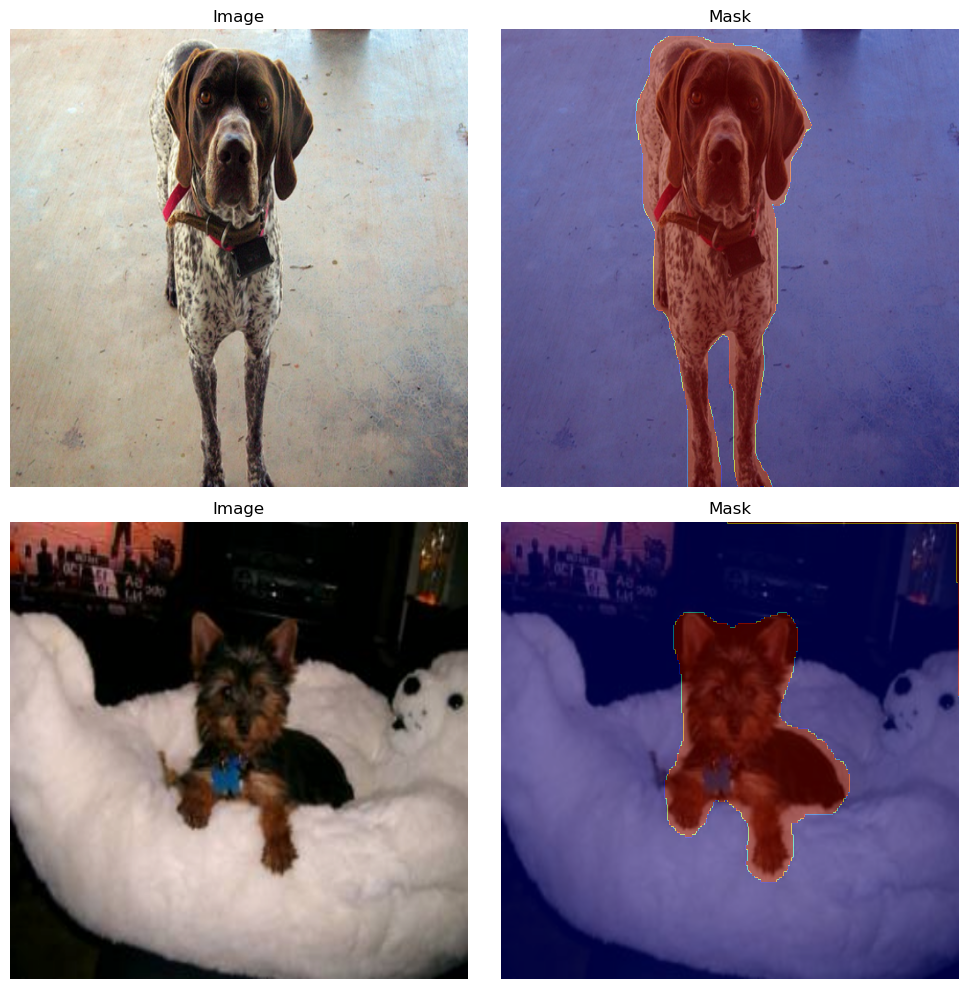

In [8]:
display_random_examples(train_dataset)

### IOU loss function/metric

From [https://github.com/kevinzakka/pytorch-goodies](https://github.com/kevinzakka/pytorch-goodies)

In [9]:

def IoU(preds, targs, device='cuda', eps: float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]

    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = (torch.eye(num_classes + 1).to(device)
                      [targs.squeeze(1).to(torch.int64)])
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)

    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        true_1_hot = (torch.eye(num_classes).to(device)
                      [targs.squeeze(1).to(torch.int64)])

        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()

        # Take softmax along class dimension; 
        # all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)

    true_1_hot = true_1_hot.type(preds.type())

    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)  # [class0,class1,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,...]
    union = cardinality - intersection
    iou = (intersection / (union+eps)).mean()  # find mean class IoU values
    return iou

### Custom [PyTorch Lighnting module](https://lightning.ai/docs/pytorch/stable/starter/introduction.html)

In [10]:
class SegModel(pl.LightningModule):
    def __init__(self, model, batch_size, lr, train_dataset, valid_dataset):
        super(SegModel, self).__init__()
        self.net = model
        self.batch_size = batch_size
        self.learning_rate = lr
        self.trainset = train_dataset
        self.valset = valid_dataset
        self.criterion = nn.BCEWithLogitsLoss()


    def forward(self, x):
        return self.net(x)


    def training_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)['out'] # [B, 1, H, W]
        loss_val = self.criterion(out.squeeze(1), mask.float()) 
        iou_score = IoU(out, mask)
        self.log('train_loss', loss_val, prog_bar=True)
        self.log('train_iou', iou_score, prog_bar=True)
        return loss_val


    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]


    def train_dataloader(self):
        return DataLoader(self.trainset, 
                          batch_size=self.batch_size, 
                          shuffle=True, num_workers=os.cpu_count())

    
    def val_dataloader(self):
        return DataLoader(self.valset, 
                          batch_size=self.batch_size, 
                          shuffle=False, num_workers=os.cpu_count())

    
    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)['out']
        loss_val = self.criterion(out.squeeze(1), mask.float())
        iou_score = IoU(out, mask)
        self.log('val_loss', loss_val, prog_bar=True)
        self.log('val_iou', iou_score, prog_bar=True)

### The model and its training

We use LRASPP, the lightest pretrained semantic segmentation model available currently in the [official PyTorch library](https://pytorch.org/vision/stable/models.html#semantic-segmentation). The model is based on the MobileNetV3 backbone and contains 3.2 mln parameters, 2.09 GFLOPS. We change the classifier layers and make the fine-tuning of the model.

In [11]:
model = torchvision.models.segmentation.lraspp_mobilenet_v3_large(
    weights='DEFAULT')
model.classifier.low_classifier = nn.Conv2d(
    40, 1, kernel_size=(1, 1), stride=(1, 1))
model.classifier.high_classifier = nn.Conv2d(
    128, 1, kernel_size=(1, 1), stride=(1, 1))
for params in model.parameters():
    params.requires_grad = True
    
all_params = sum(p.numel() for p in model.parameters())
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'No of parameters: {all_params}')
print(f'No of trainable parameters: {train_params}')  

Downloading: "https://download.pytorch.org/models/lraspp_mobilenet_v3_large-d234d4ea.pth" to /root/.cache/torch/hub/checkpoints/lraspp_mobilenet_v3_large-d234d4ea.pth
100%|██████████| 12.5M/12.5M [00:00<00:00, 101MB/s] 

No of parameters: 3218138
No of trainable parameters: 3218138


In [ ]:
lmodel = SegModel(model, BATCH_SIZE, 1e-4, train_dataset, valid_dataset)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_iou'),
        LearningRateMonitor('epoch'),
        EarlyStopping(monitor='val_iou', mode='max', patience=15),
    ],  
)

trainer.fit(lmodel)

Saving the model

In [13]:
torch.save(lmodel.state_dict(), WORKING/'segmentation.pt')

### Validation

In case the previously saved results need to be loaded:

In [ ]:
#model = torchvision.models.segmentation.lraspp_mobilenet_v3_large()
#model.classifier.low_classifier = nn.Conv2d(
#    40, 1, kernel_size=(1, 1), stride=(1, 1))
#model.classifier.high_classifier = nn.Conv2d(
#    128, 1, kernel_size=(1, 1), stride=(1, 1))
#
#lmodel = SegModel(model, BATCH_SIZE, 1e-4, train_dataset, valid_dataset)
#lmodel.load_state_dict(torch.load('segmentation.pt'))
#
#trainer = pl.Trainer(
#    max_epochs=50,
#    callbacks=[
#        ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_iou'),
#        LearningRateMonitor('epoch'),
#        EarlyStopping(monitor='val_iou', mode='max', patience=15),
#    ],  
#)

In [14]:
trainer.validate(lmodel, 
                 dataloaders=lmodel.val_dataloader())

Validation: 0it [00:00, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.9031367301940918     │
│         val_loss          │    0.09702225774526596    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.09702225774526596, 'val_iou': 0.9031367301940918}]

### Viewing TensorBoard logs

Uncomment and run the following cell on your local machine to look at the graphics of loss functions and metrics during the training (the logs are in the 'lightning_logs' directory).

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir lightning_logs

### The predicted masks vs ground truth contours

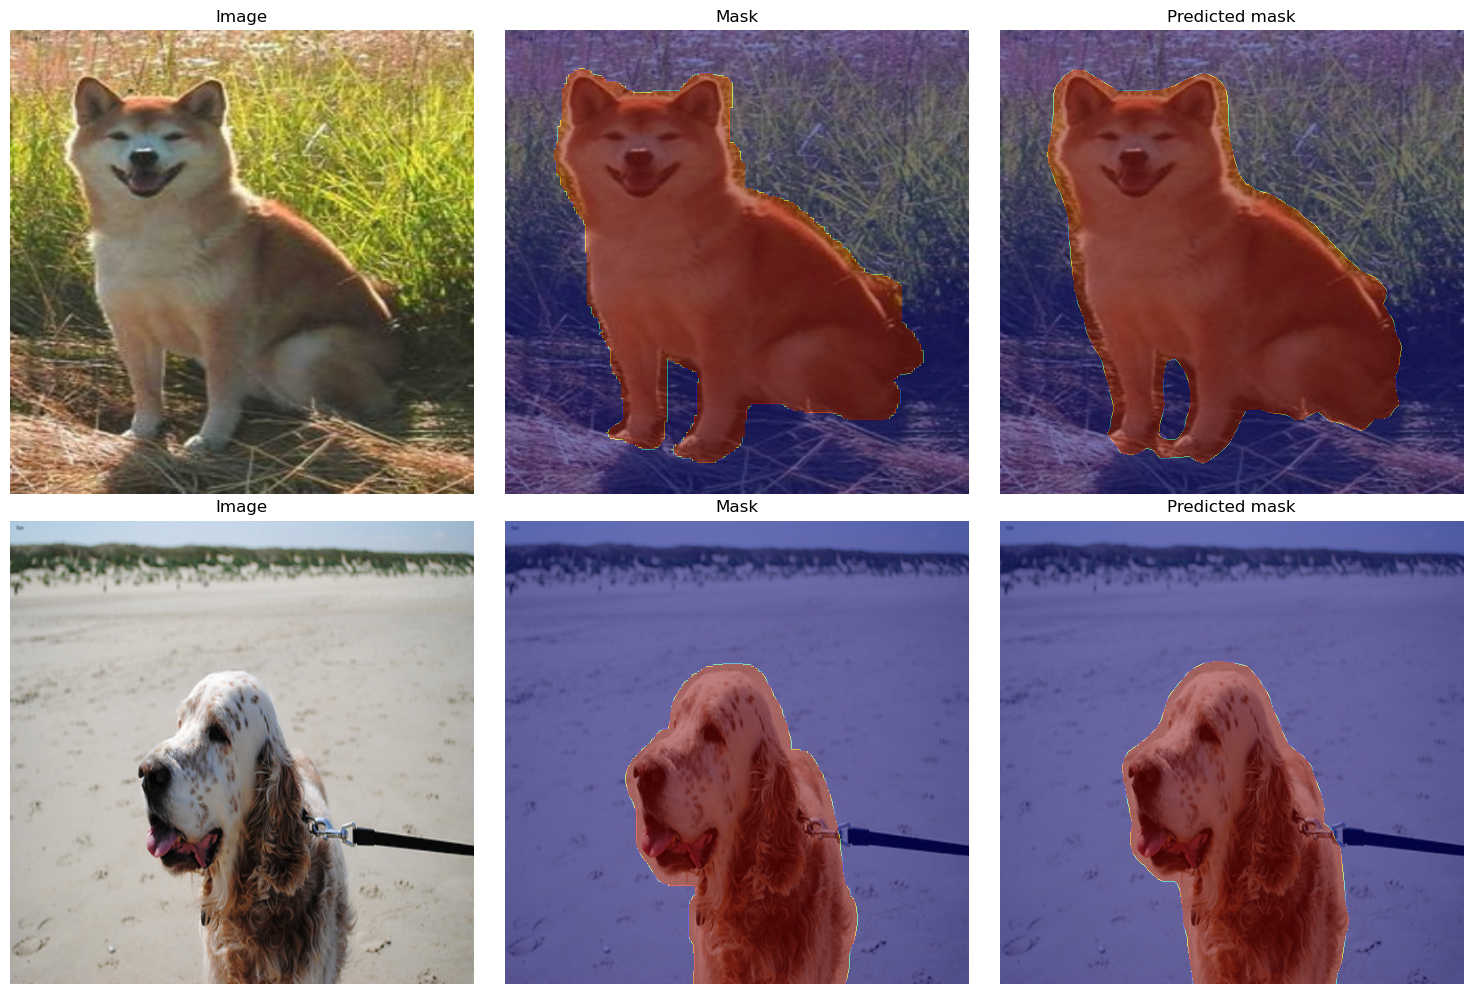

In [15]:
display_random_examples(valid_dataset, model=lmodel)